In [9]:
import torch
import config
import numpy as np
import matplotlib.pyplot as plt
import os
from Alg.solving_algorithm import ModelGenerator
from CustomModels.my_models import Integrator
from CustomModels.my_models import weighted_amount,renormolize_distribution
from aml.plotting import *
from Losses.Losses import *
from sklearn import decomposition
from tqdm import tqdm
from scipy.spatial import ConvexHull
from scipy.optimize import minimize

def adjust_alpha(alpha_n):
    for j in range(len(alpha_n)):
        if alpha_n[j]<0.0:
            alpha_n[j] = 0.0
        elif alpha_n[j] > 1.0:
            alpha_n[j] = 1.0
    alpha_n = alpha_n/np.sum(alpha_n)
    return alpha_n 

def grad_descent_from_alpha_in_simplex(alpha_vec,p_list, shared_integration_supports):
    d = len(p_list)
    alpha_n = np.copy(alpha_vec)
    alpha_n = alpha_n/np.sum(alpha_n)
    n = 0
    p_mid = None
    L_mid = None
    all_losses = []
    while True:
        p_mid = weighted_amount(list_of_distributions=p_list, alpha_list=alpha_n)
        L_mid = get_L2_Distrib4D(p_mid,shared_integration_supports)
        gradient_ = np.zeros(shape=(d,))
        alpha_not_zero = alpha_n[np.argwhere(alpha_n != 0.0)]
        alpha_min_ = np.min(alpha_not_zero)
        # epsilon_ = np.minimum(alpha_min_/2.0, 1.0/d)
        epsilon_ = 10**(-3)
        for j in range(d):
            if alpha_n[j] < epsilon_:
                alpha_1 = np.copy(alpha_n)
                alpha_1[j] = alpha_1[j] + epsilon_
                p_1 = weighted_amount(list_of_distributions=p_list, alpha_list=alpha_1)
                L_1 = get_L2_Distrib4D(p_1,shared_integration_supports)
                gradient_[j] = (L_1 - L_mid)/epsilon_
                continue
            if alpha_n[j] > 1.0-epsilon_:
                alpha_2 = np.copy(alpha_n)
                alpha_2[j] = alpha_2[j] - epsilon_
                p_2 = weighted_amount(list_of_distributions=p_list, alpha_list=alpha_2)
                L_2 = get_L2_Distrib4D(p_2,shared_integration_supports)
                gradient_[j] = (L_mid-L_2)/epsilon_
                continue

            alpha_1 = np.copy(alpha_n)
            alpha_1[j] = alpha_1[j] + epsilon_
            alpha_2 = np.copy(alpha_n)
            alpha_2[j] = alpha_2[j] - epsilon_

            p_1 = weighted_amount(list_of_distributions=p_list, alpha_list=alpha_1)
            p_2 = weighted_amount(list_of_distributions=p_list, alpha_list=alpha_2)

            L_1 = get_L2_Distrib4D(p_1,shared_integration_supports)
            L_2 = get_L2_Distrib4D(p_2,shared_integration_supports)
            # print(L_1,L_2, epsilon_)
            gradient_[j] = (L_1 - L_2)/(2*epsilon_)
        

        lambda_vec = np.logspace(start=4,stop=-4,num=10)
        lambda_best = None
        loss_current = L_mid
        ls = []
        lambda_ls = []
        for lambda_ in lambda_vec:
            alpha_copy = np.copy(alpha_n)
            alpha_after = alpha_copy - lambda_*gradient_
            if np.sum(alpha_after < 0.0)==d:
                continue
            alpha_after = adjust_alpha(alpha_after)        
            p_after = weighted_amount(list_of_distributions=p_list, alpha_list=alpha_after)
            L_after = get_L2_Distrib4D(p_after,shared_integration_supports)
            ls.append(L_after)
            lambda_ls.append(lambda_)
            if L_after<loss_current:
                loss_current = L_after
                lambda_best = lambda_
        # arg_best = np.argsort(ls)[0]
        # left_pos = np.maximum(0, arg_best-1)
        # right_pos = np.minimum(len(ls)-1, arg_best+1)

        # left = lambda_ls[left_pos]
        # right = lambda_ls[right_pos]

        # lambda_vec = np.linspace(left,right,10)
        # addls = []
        # addlambda_ls = []
        # for lambda_ in lambda_vec:
        #     alpha_copy = np.copy(alpha_n)
        #     alpha_after = alpha_copy - lambda_*gradient_
        #     if np.sum(alpha_after < 0.0)==d:
        #         continue
        #     alpha_after = adjust_alpha(alpha_after)        
        #     p_after = weighted_amount(list_of_distributions=p_list, alpha_list=alpha_after)
        #     L_after = get_L2_Distrib4D(p_after,shared_integration_supports)
        #     addls.append(L_after)
        #     addlambda_ls.append(lambda_)
        #     if L_after<loss_current:
        #         loss_current = L_after
        #         lambda_best = lambda_
        # fig,ax = plt.subplots()
        # ax.plot(lambda_ls,ls,color= 'k')
        # ax.plot(addlambda_ls,addls,color= 'r')
        # plt.show()
        

        all_losses.append(loss_current)
        if loss_current == L_mid:
            break        

        alpha_n = alpha_n - lambda_best*gradient_
        alpha_n = adjust_alpha(alpha_n)        

        # board_reference.Push(experiment_metadata=experiment_metadata,
        #     x=n,y= lambda_best, label='best_lambda')
        
        # board_reference.Push(experiment_metadata=experiment_metadata,
        #     x=n,y= np.linalg.norm(gradient_), label='grad_norm')

        n+=1
    
    return p_mid, L_mid

def approx_equal(x1,x2,precision):
    if np.absolute(x1-x2) < precision:
        return True
    else:
        return False

# def search_min_in_simplex_with_center(L_0,p_list,mid_of_simplex,simplex, shared_integration_supports):
#     pos_of_mid = np.argwhere(simplex==mid_of_simplex).flatten()[0]
#     d = len(p_list)
#     all_losses = []
#     # eps_vec = np.concatenate([np.linspace(0, 1.0, 10),np.logspace(-1,-6,10)])
#     eps_vec = np.linspace(0.1, 0.9, 5)
#     p_n = None
#     L_n = 10**99
#     loss_n = []
#     n_ = []
#     for ITER in range(10):
#         min_L_in_iter = 10**99
#         if ITER==0:
#             for i in range(len(simplex)):
#                 if mid_of_simplex == simplex[i]:
#                     continue
#                 for j in range(len(eps_vec)):
#                     eps_= eps_vec[j]
#                     p_j = weighted_amount(list_of_distributions=[p_list[pos_of_mid], p_list[i]], alpha_list=[1.0-eps_, eps_])
#                     L_j = get_L2_Distrib4D(p_j, shared_integration_supports)
#                     if (L_j < min_L_in_iter):
#                         min_L_in_iter = L_j
#                     if (L_j < L_n) or approx_equal(L_j, L_n, 10**(-4)):
#                         L_n = L_j
#                         p_n = p_j
#         else:
#             for i in range(len(simplex)):
#                 for j in range(len(eps_vec)):
#                     eps_= eps_vec[j]
#                     p_j = weighted_amount(list_of_distributions=[p_n, p_list[i]], alpha_list=[1.0-eps_, eps_])
#                     L_j = get_L2_Distrib4D(p_j, shared_integration_supports)
#                     if (L_j < min_L_in_iter):
#                         min_L_in_iter = L_j
#                     if (L_j < L_n) or approx_equal(L_j, L_n, 10**(-4)):
#                         L_n = L_j
#                         p_n = p_j
#         if approx_equal(L_n, L_0,10**(-4)):
#             break 
#         print('ITER {} LOSS {}'.format(ITER, L_n))
#         loss_n.append(L_n)
#         n_.append(ITER)
#         if min_L_in_iter >= L_0:
#             break

#     if L_n > L_0:
#         return p_list[pos_of_mid], L_0
#     else:
#         return p_n, L_n

def search_min_in_simplex_with_center(
                                      Lstorage,
                                      MutationMask,
                                      simplex,
                                      mid_of_simplex,
                                      L_0,
                                      p_list,
                                      MAX_ITER,
                                      shared_integration_supports
                                      ):
    d = len(p_list)
    pos_of_mid = np.argwhere(simplex==mid_of_simplex).flatten()[0]
    
    alpha_n = np.zeros(shape=(d, ))
    alpha_n[pos_of_mid] = 1.0
    
    alpha_n = alpha_n/np.sum(alpha_n)
    p_n = weighted_amount(list_of_distributions=p_list, alpha_list=alpha_n)
    L_n = get_L2_Distrib4D(p_n, shared_integration_supports)

    best_alpha_n = None
    best_L = L_n
    # append first value of loss
    Lstorage.append(L_n)
    MutationMask.append(-1)
    
    print('start of alg')
    for ITER in range(MAX_ITER):

        # make step 
        p_n=  weighted_amount(list_of_distributions=p_list, alpha_list=alpha_n)
        L_n = get_L2_Distrib4D(p_n,shared_integration_supports)
        # Lstorage.append(L_n)

        gradient_ = np.zeros(shape=(d,))
        epsilon_ = 10**(-1)
        for j in range(d):
            if alpha_n[j] < epsilon_:
                alpha_1 = np.copy(alpha_n)
                alpha_1[j] = alpha_1[j] + epsilon_
                alpha_1 = alpha_1/np.sum(alpha_1)

                p_1 = weighted_amount(list_of_distributions=p_list, alpha_list=alpha_1)
                L_1 = get_L2_Distrib4D(p_1,shared_integration_supports)
                gradient_[j] = (L_1 - L_n)/epsilon_
                continue
            if alpha_n[j] > 1.0-epsilon_:
                alpha_2 = np.copy(alpha_n)
                alpha_2[j] = alpha_2[j] - epsilon_
                alpha_2 = alpha_2/np.sum(alpha_2)
                p_2 = weighted_amount(list_of_distributions=p_list, alpha_list=alpha_2)
                L_2 = get_L2_Distrib4D(p_2,shared_integration_supports)
                gradient_[j] = (L_n-L_2)/epsilon_
                continue
            
            alpha_1 = np.copy(alpha_n)
            alpha_1[j] = alpha_1[j] + epsilon_
            alpha_2 = np.copy(alpha_n)
            alpha_2[j] = alpha_2[j] - epsilon_
            
            alpha_1 = alpha_1/np.sum(alpha_1)
            alpha_2 = alpha_2/np.sum(alpha_2)


            p_1 = weighted_amount(list_of_distributions=p_list, alpha_list=alpha_1)
            p_2 = weighted_amount(list_of_distributions=p_list, alpha_list=alpha_2)


            L_1 = get_L2_Distrib4D(p_1,shared_integration_supports)
            L_2 = get_L2_Distrib4D(p_2,shared_integration_supports)
            gradient_[j] = (L_1 - L_2)/(2*epsilon_)

        lambda_vec = np.logspace(start=4,stop=-4,num=10)
        lambda_best = None
        loss_current = L_n
        ls = []
        lambda_ls = []
        for lambda_ in lambda_vec:
            alpha_copy = np.copy(alpha_n)
            alpha_after = alpha_copy - lambda_*gradient_
            if np.sum(alpha_after < 0.0)==d:
                continue
            alpha_after = adjust_alpha(alpha_after)        
            p_after = weighted_amount(list_of_distributions=p_list, alpha_list=alpha_after)
            L_after = get_L2_Distrib4D(p_after,shared_integration_supports)
            ls.append(L_after)
            lambda_ls.append(lambda_)
            if L_after<loss_current:
                loss_current = L_after
                lambda_best = lambda_
        arg_best = np.argsort(ls)[0]
        left_pos = np.maximum(0, arg_best-1)
        right_pos = np.minimum(len(ls)-1, arg_best+1)

        left = lambda_ls[left_pos]
        right = lambda_ls[right_pos]

        lambda_vec = np.linspace(left,right,10)
        addls = []
        addlambda_ls = []
        for lambda_ in lambda_vec:
            alpha_copy = np.copy(alpha_n)
            alpha_after = alpha_copy - lambda_*gradient_
            if np.sum(alpha_after < 0.0)==d:
                continue
            alpha_after = adjust_alpha(alpha_after)        
            p_after = weighted_amount(list_of_distributions=p_list, alpha_list=alpha_after)
            L_after = get_L2_Distrib4D(p_after,shared_integration_supports)
            addls.append(L_after)
            addlambda_ls.append(lambda_)
            if L_after<loss_current:
                loss_current = L_after
                lambda_best = lambda_
                
        if lambda_best == None:
            alpha_n = alpha_n + epsilon_*np.random.rand(d)
            alpha_n = alpha_n/np.sum(alpha_n)
            MutationMask.append(1)
        else:
            # fig,ax = plt.subplots()
            # ax.plot(lambda_ls, ls)
            # ax.set_xscale('log')
            # plt.show()
            MutationMask.append(0)
            alpha_n = alpha_n - lambda_best*gradient_
            alpha_n = adjust_alpha(alpha_n)
            # print(alpha_n)
            # torch.save(alpha_n, os.path.join(config.task_dir,'alpha_rules_descent.txt'))

        p_n =  weighted_amount(list_of_distributions=p_list, alpha_list=alpha_n)
        L_n = get_L2_Distrib4D(p_n,shared_integration_supports)
        Lstorage.append(L_n)
        print('ITER {} L_n {}'.format(ITER,L_n))
        if L_n < best_L:
            best_alpha_n = alpha_n
            best_L = L_n

    if best_alpha_n is not None:
        p_final = weighted_amount(list_of_distributions=p_list, alpha_list=best_alpha_n)
        L_final = best_L
        alpha_final  = best_alpha_n
        return p_final, L_final, alpha_final
    else:
        print('меньшее значение не найдено')
        return None

def make_obj_func(p_list_in_simplex, shared_integration_supports):
    def get_l_by_alpha(alpha_vec):
        p_ = weighted_amount(list_of_distributions=p_list_in_simplex, alpha_list=alpha_vec)
        L_ = get_L2_Distrib4D(p_, shared_integration_supports)
        return L_
    return get_l_by_alpha

def grad_descent(L_0,p_list,mid_of_siplex,simplex, shared_integration_supports):
    # p_n, L_n = search_min_in_simplex_with_center(L_0,mid_of_siplex, simplex,p_list, shared_integration_supports) 
    # return p_n, L_n
    # alpha_vec = np.zeros(shape=(len(p_list),))
    # pos_of_mid = np.argwhere(simplex==mid_of_siplex).flatten()[0]
    # alpha_vec[pos_of_mid] = 1.0
    # p_mid, L_mid = grad_descent_from_alpha_in_simplex(alpha_vec,p_list, shared_integration_supports)
    # return p_mid, L_mid
    
    # fmincon

    d = len(p_list)
    print('dimension of problem {}'.format(d))
    alpha_0 = np.zeros(shape=(len(p_list),))
    pos_of_mid = np.argwhere(simplex==mid_of_siplex).flatten()[0]
    alpha_0[pos_of_mid] = 1.0
    obj_func = make_obj_func(p_list, shared_integration_supports)
    start_Loss = obj_func(alpha_0)
    print('start from {}'.format(start_Loss))
    # start_ = time.time()
    # for i in range(10):
    #     result_ = obj_func(alpha_0)
    # delta_ = time.time()-start_

    # print('time per iter {}'.format(delta_/10.0))
    # raise SystemExit
    bounds = np.zeros(shape=(d,2))
    for j in range(d):
        bounds[j][0] = 0.0
        bounds[j][1] = 1.0
    cons = [{"type": "eq", "fun": lambda x: np.sum(x)-1.0}]

    options = {
        'verbose':2
    }

    results = minimize(fun=obj_func, x0=alpha_0,method='trust-constr', bounds=bounds,constraints=cons,options=options)
    best_alpha = results['x']
    print(results)
    print(best_alpha)
    print('init vertex {}'.format(pos_of_mid))
    fig0,ax0= plt.subplots()
    fig0.set_size_inches(16,9)
    ax0.bar(x= np.arange(0,d),height=best_alpha)
    ax0.set_title(r'$P_{\gamma}(k)$')
    # ax0.set_xlim(-1,50)
    ax0.set_xlabel(r'$k$')
    plt.show()
    raise SystemExit
def set_font_size_to(ax,font_size=None):
    if font_size is not None:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                    ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(font_size)

def save_plot_to(fig, path):
    fig.savefig(path, bbox_inches = 'tight')

In [5]:
board = TensorBoard(tensorboard_exe_path=config.tensorboard_path,
                    logdir=os.path.join(config.task_dir, 'descent_log'),
                    port= '64002')

tensorboard http://localhost:64002/


2024-04-24 21:06:59.869695: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 21:06:59.869722: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 21:06:59.869745: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 21:06:59.874586: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 21:07:00.494609: W tensorflow/compiler/

In [2]:
mg = ModelGenerator(rules=config.rules,
                            cache_dir=config.Phi_cache_dir,
                            clear_cache=False)
N=1000
all_p = [torch.load(os.path.join(mg.cache_dir, 'distrib4D_{}.txt'.format(i))) for i in range(N)]
nr = len(all_p[0].z_list)
uniform_distrib_of_rules= np.ones(shape=(nr,))/nr
a, h, f, coeff_list = mg.shared_data['ahfcoeff_list']
for i in range(N):
    all_p[i] = renormolize_distribution(all_p[i],[a[el].detach().numpy() for el in range(len(a))],uniform_distrib_of_rules)


vectors = torch.load(config.Phi_vector_representation)
all_v = torch.load(os.path.join(config.task_dir, 'L2_for_Phi.txt'))
# plot_float_distribution(all_v)
# raise SystemExit
# print(np.sort(all_v))
simplices = torch.load(os.path.join(config.task_dir, 'triangulation_simplexes.txt'))
sorted_vertesices = [el for el in np.argsort(all_v)]  # from best(minimal) to worst(highest) value of Loss
sorted_values = np.sort(all_v)

simplexes_for_optimization = []
central_vertexes = []
central_values = []
for i in tqdm(range(len(sorted_vertesices))):
    best_vertex = sorted_vertesices[i]
    # best vertex is ith distipution
    # ith distribution is mid vertex of ith simplex for opt
    ith_group = []
    
    for simplex in simplices:
        if best_vertex in simplex:
            ith_group.append(simplex)
    
    if len(ith_group) == 0:
        continue
    else:
        central_vertexes.append(best_vertex)
        # bug
        # if len(ith_group) != len(np.unique(ith_group)):
            # print('warning')
        simplexes_for_optimization.append(np.unique(ith_group))
        central_values.append(sorted_values[i])

print('number of simplexes for oprimization {}'.format(len(simplexes_for_optimization)))
# print('len of simplex {}'.format(len(simplexes_for_optimization[0])))

d = len(vectors[0])
# support_vertexes = torch.load(os.path.join(config.task_dir, 'support_points.txt'))

mg = ModelGenerator(rules=config.rules,
                            cache_dir=config.Phi_cache_dir,
                            clear_cache=False)
shared_integration_supports = Integrator(dir_=config.integrator_dir,
                                        shared_data=mg.shared_data,
                                        clear_cache=True).shared_integration_supports

100%|██████████| 1000/1000 [01:37<00:00, 10.29it/s]


number of simplexes for oprimization 487
     num_of_rect_in_intersection 17090


d = 5
vector repr shape  (1000, 5)
simplexes shape  (45942, 6)


Text(0.5, 1.0, 'n of unique values 97\nsimplexes for opt distr of len')

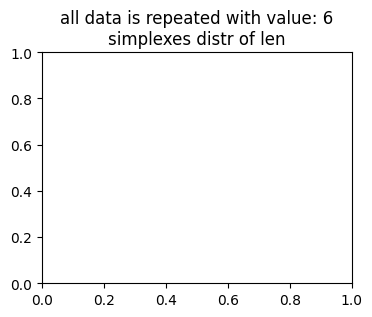

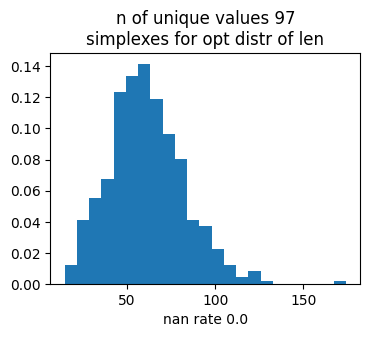

In [3]:
print(f'd = {d}')
print('vector repr shape ',vectors.shape)
print('simplexes shape ',simplices.shape)
fig,ax =plot_float_distribution([len(el) for el in simplices])
ax.set_title(ax.title.get_text() + '\nsimplexes distr of len')
fig,ax =plot_float_distribution([len(el) for el in simplexes_for_optimization])
ax.set_title(ax.title.get_text() + '\nsimplexes for opt distr of len')

In [16]:
print('start best {}'.format(np.min(central_values)))
global_L_min = 10**99
p_best_gl = None
# losses_per_simplex_optimization = {i:[] for i in range(len(sorted_simplixes))}
# max_iter = np.maximum(int(0.005*len(sorted_simplixes)),1)
max_iter = np.minimum(4,len(simplexes_for_optimization)) # number of groups to be optimized inside
Lstorages = []
Mmasks = []
simplex_index = []
MAX_ITER = 10

all_avaliable_indexes = [i for i in range(len(simplexes_for_optimization))]

for i in tqdm(range(max_iter)):
    # вместо i выберем рандомный j 
    j = None 
    if i>0:
        j = np.random.choice(all_avaliable_indexes)
    else:
        j = all_avaliable_indexes[0]

    all_avaliable_indexes = np.setdiff1d(all_avaliable_indexes, j).tolist()
    
    simplex_index.append(j)
    # j = np.random.randint(0, len(sorted_simplixes))
    # simplex = sorted_simplixes[j]
    # BestOfSimplex = simplexes_best[j]
    simplex = simplexes_for_optimization[j]
    p_in_simplex = [all_p[el] for el in simplex]
    mid_of_simplex = central_vertexes[j]
    BestOfSimplex = central_values[j]

    L_0 = BestOfSimplex

    # p_best, L_best = grad_descent(L_0,p_in_simplex,mid_of_simplex,simplex, shared_integration_supports)
    # p_best, L_best = search_min_in_simplex_with_center(L_0,p_in_simplex,mid_of_simplex,simplex, shared_integration_supports)
    Lstorage = []
    MutationMask = []
    p_best, L_best, alpha_best = search_min_in_simplex_with_center(
                                      Lstorage,
                                      MutationMask,
                                      simplex,
                                      mid_of_simplex,
                                      L_0,
                                      p_in_simplex,
                                      MAX_ITER,
                                      shared_integration_supports
                                      )
    Lstorages.append(Lstorage.copy())
    Mmasks.append(MutationMask.copy())

    if L_best < global_L_min:
        global_L_min = L_best
        p_best_gl = p_best
        torch.save(p_best_gl, config.Phi_descent_best_p_path)
    
    print('simplex L_0 {} simplex fitted L {}'.format(BestOfSimplex, L_best))

print(global_L_min)

start best 0.7276974228689813


  0%|          | 0/4 [00:00<?, ?it/s]

start of alg
ITER 0 L_n 0.7147765323180338
ITER 1 L_n 0.7088048312670006
ITER 2 L_n 0.7563358832558928
ITER 3 L_n 0.727866556965111
ITER 4 L_n 0.7210326371067204
ITER 5 L_n 0.7594092036614317
ITER 6 L_n 0.7407579568477319
ITER 7 L_n 0.7177373009424122
ITER 8 L_n 0.7172270935751978


 25%|██▌       | 1/4 [04:22<13:07, 262.42s/it]

ITER 9 L_n 0.7158329330975464
simplex L_0 0.7276974228689813 simplex fitted L 0.7088048312670006
start of alg
ITER 0 L_n 0.7612618902742515
ITER 1 L_n 0.749543280022534
ITER 2 L_n 0.735678181755493
ITER 3 L_n 0.7646172114467445
ITER 4 L_n 0.7476622412198676
ITER 5 L_n 0.7334489345126787
ITER 6 L_n 0.7307888408964736
ITER 7 L_n 0.7694669673623038
ITER 8 L_n 0.7640691754784049


 50%|█████     | 2/4 [07:06<06:49, 204.73s/it]

ITER 9 L_n 0.7586179203987826
simplex L_0 0.7645099568401013 simplex fitted L 0.7307888408964736
start of alg
ITER 0 L_n 0.7624896338270422
ITER 1 L_n 0.7560319368874587
ITER 2 L_n 0.7506362164304592
ITER 3 L_n 0.7285094189661123
ITER 4 L_n 0.7278425292499091
ITER 5 L_n 0.7733057747457619
ITER 6 L_n 0.7652232412007978
ITER 7 L_n 0.7344372974743248
ITER 8 L_n 0.7237165487375665


 75%|███████▌  | 3/4 [11:02<03:38, 218.81s/it]

ITER 9 L_n 0.7635604973037614
simplex L_0 0.7863063049986159 simplex fitted L 0.7237165487375665
start of alg
ITER 0 L_n 0.7685383024744717
ITER 1 L_n 0.7763793793412426
ITER 2 L_n 0.76852431345898
ITER 3 L_n 0.7191248194639985
ITER 4 L_n 0.7188405131035335
ITER 5 L_n 0.7145827227237053
ITER 6 L_n 0.714351071222897
ITER 7 L_n 0.7127584833590022
ITER 8 L_n 0.7725935814497249


100%|██████████| 4/4 [14:07<00:00, 211.85s/it]

ITER 9 L_n 0.7659433086135123
simplex L_0 0.7738281070410105 simplex fitted L 0.7127584833590022
0.7088048312670006


In [5]:
path_to_save = config.plots_simplex_descent_path

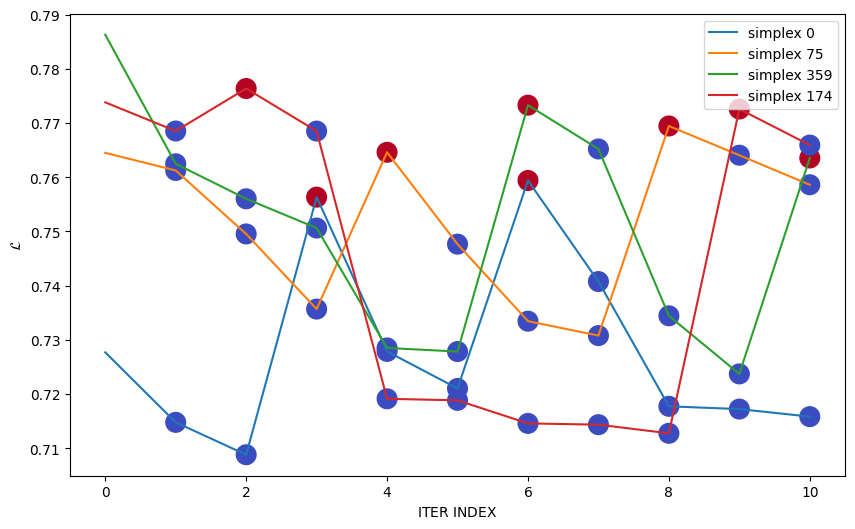

In [17]:
fig,ax = plt.subplots()
fig.set_size_inches(10,6)


for i in range(len(Lstorages)):
    Lstorage = Lstorages[i].copy()
    MutationMaskCopy = Mmasks[i].copy()
    ax.plot(np.arange(len(Lstorage)),Lstorage,label = f'simplex {simplex_index[i]}')
    ax.scatter(np.arange(len(Lstorage)-1)+1, Lstorage[1:], marker='o',c = MutationMaskCopy[1:],cmap='coolwarm',s = 200)

# ax.axhline(Lstorage[0],c='g',label='start',linewidth = 5)
# ax.axhline(min(Lstorage),c='y',label='best',linewidth = 5)
ax.set_ylabel(r'$\mathcal{L}$')
ax.set_xlabel(r'$\text{ITER INDEX}$')
ax.legend()
# set_font_size_to(ax,20)
# ax.legend(prop={'size': 20})
# save_plot_to(fig, os.path.join(path_to_save, 'simplex_descent_loss.png'))
